## 🌐 **Google Drive Connection**

In [2]:
# Install and configure Kaggle API
!pip install -q kaggle

from google.colab import files
print("Carica il file kaggle.json (scaricabile dal tuo profilo Kaggle)")
files.upload()  # select kaggle.json from your pc, using the API from user->setting in KAGGLE (create new token)

# Configura le credenziali
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Monta Google Drive
from google.colab import drive
drive.mount("/gdrive")

# Percorso di destinazione sul Drive
dataset_path = "/gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/dataset"
!mkdir -p {dataset_path}

# Scarica il dataset direttamente da Kaggle nella cartella scelta
!kaggle competitions download -c an2dl2526c1 -p {dataset_path}

# Decomprimi (opzionale, solo se i file sono .zip)
!unzip -o {dataset_path}/an2dl2526c1.zip -d {dataset_path}

print(f"Dataset scaricato e disponibile in: {dataset_path}")


Carica il file kaggle.json (scaricabile dal tuo profilo Kaggle)


Saving kaggle.json to kaggle.json
Mounted at /gdrive
an2dl2526c1.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/dataset/an2dl2526c1.zip
  inflating: /gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/dataset/pirate_pain_test.csv  
  inflating: /gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/dataset/pirate_pain_train.csv  
  inflating: /gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/dataset/pirate_pain_train_labels.csv  
  inflating: /gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/dataset/sample_submission.csv  
Dataset scaricato e disponibile in: /gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/dataset


## ⚙️ **Libraries Import**

In [3]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
# from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import copy
import shutil
from itertools import product
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

PyTorch version: 2.8.0+cu126
Device: cpu


## ⏳ **Data Loading**

In [4]:
import os

dataset_path = "/gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/dataset"
os.makedirs(dataset_path, exist_ok=True)

competition = "an2dl2526c1"
# file needed
dataset_files = ["pirate_pain_test.csv", "pirate_pain_train.csv", "pirate_pain_train_labels.csv"]

# Download file if not done yet
for fname in dataset_files:
    dest_path = os.path.join(dataset_path, fname)
    if not os.path.exists(dest_path):
        print(f"📥 Downloading {fname} ...")
        !kaggle competitions download -c {competition} -f {fname} -p {dataset_path}
    else:
        print(f"✅ {fname} already exists. Using cached version.")

print("\nAll files ready in:", dataset_path)


✅ pirate_pain_test.csv already exists. Using cached version.
✅ pirate_pain_train.csv already exists. Using cached version.
✅ pirate_pain_train_labels.csv already exists. Using cached version.

All files ready in: /gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/dataset


## 🔎 **Exploration and Data Analysis**

In [42]:
df_train = pd.read_csv(os.path.join(dataset_path, "pirate_pain_train.csv"))

# drop null features (there are not, I previously check that)
df_train.dropna(axis=0, how='any', inplace=True)
print(f"DataFrame shape: {df_train.shape}")

print(df_train.info())
print(df_train.describe())

DataFrame shape: (105760, 40)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105760 entries, 0 to 105759
Data columns (total 40 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sample_index   105760 non-null  int64  
 1   time           105760 non-null  int64  
 2   pain_survey_1  105760 non-null  int64  
 3   pain_survey_2  105760 non-null  int64  
 4   pain_survey_3  105760 non-null  int64  
 5   pain_survey_4  105760 non-null  int64  
 6   n_legs         105760 non-null  object 
 7   n_hands        105760 non-null  object 
 8   n_eyes         105760 non-null  object 
 9   joint_00       105760 non-null  float64
 10  joint_01       105760 non-null  float64
 11  joint_02       105760 non-null  float64
 12  joint_03       105760 non-null  float64
 13  joint_04       105760 non-null  float64
 14  joint_05       105760 non-null  float64
 15  joint_06       105760 non-null  float64
 16  joint_07       105760 non-null  float64
 17 

In [6]:
# 4 int64 features: discrete variables (time and sample_index are not considered)
#                   for now just convert into float32, leaving the 0,1,2
# 3 object: categorical features -> what are their type, and how many counts for each type
# 31 float: qualitatives features -> convert in float32 (as in the labs)

# joint_30 has variance = 0 -> drop it, doesn't add anything to the model


In [43]:
n_legs = df_train['n_legs'].unique()
n_hands = df_train['n_hands'].unique()
n_eyes = df_train['n_eyes'].unique()

print("Unique values in n_legs:", n_legs)
print("Unique values in n_hands:", n_hands)
print("Unique values in n_eyes:", n_eyes)

id_peg_leg = df_train[df_train['n_legs'] == 'one+peg_leg']['sample_index'].unique()
print('Pirates with peg_leg: ', id_peg_leg)
id_hook_hand = df_train[df_train['n_hands'] == 'one+hook_hand']['sample_index'].unique()
print('Pirates with hook_hand: ', id_hook_hand)
id_eye_patch = df_train[df_train['n_eyes'] == 'one+eye_patch']['sample_index'].unique()
print('Pirates with eye_patch: ', id_eye_patch)

# since we clearly have two distint class of pirates: healthy and injured, we can drop the 3 features and add
# a new features that represent that.
# this becouse they are coherent among them, the same pirate has all the three injury
df_train['is_injured'] = np.where(df_train['n_legs'] != 'two', 1, 0).astype('float32')
df_train = df_train.drop(columns=['n_legs', 'n_hands', 'n_eyes'])

# drop the joint_30 since has variance = 0
df_train = df_train.drop(columns=['joint_30'])


Unique values in n_legs: ['two' 'one+peg_leg']
Unique values in n_hands: ['two' 'one+hook_hand']
Unique values in n_eyes: ['two' 'one+eye_patch']
Pirates with peg_leg:  [  8 137 216 338 350 496]
Pirates with hook_hand:  [  8 137 216 338 350 496]
Pirates with eye_patch:  [  8 137 216 338 350 496]


In [44]:

pain_survay1 = df_train['pain_survey_1'].unique()
pain_survay2 = df_train['pain_survey_2'].unique()
pain_survay3 = df_train['pain_survey_3'].unique()
pain_survay4 = df_train['pain_survey_4'].unique()
print("Unique values in pain_survey1:", pain_survay1)
print("Unique values in pain_survey2:", pain_survay2)
print("Unique values in pain_survey3:", pain_survay3)
print("Unique values in pain_survey4:", pain_survay4)

all_pain_survay = ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']
# convert int64 into float32 -> should we do categorical embeddings ?
df_train[all_pain_survay] = df_train[all_pain_survay].astype(np.float32)

continuous_features = ['joint_00', 'joint_01', 'joint_02', 'joint_03', 'joint_04', 'joint_05', 'joint_06',
                       'joint_07', 'joint_08', 'joint_09','joint_10', 'joint_11', 'joint_12', 'joint_13',
                       'joint_14', 'joint_15', 'joint_16', 'joint_17', 'joint_18', 'joint_19', 'joint_20',
                       'joint_21', 'joint_22', 'joint_23', 'joint_24', 'joint_25', 'joint_26', 'joint_27',
                       'joint_28', 'joint_29']

df_train[continuous_features] = df_train[continuous_features].astype(np.float32)


Unique values in pain_survey1: [2 0 1]
Unique values in pain_survey2: [0 2 1]
Unique values in pain_survey3: [2 0 1]
Unique values in pain_survey4: [1 2 0]


In [45]:
# Display updated DataFrame information
print(df_train.info())
print(df_train.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105760 entries, 0 to 105759
Data columns (total 37 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sample_index   105760 non-null  int64  
 1   time           105760 non-null  int64  
 2   pain_survey_1  105760 non-null  float32
 3   pain_survey_2  105760 non-null  float32
 4   pain_survey_3  105760 non-null  float32
 5   pain_survey_4  105760 non-null  float32
 6   joint_00       105760 non-null  float32
 7   joint_01       105760 non-null  float32
 8   joint_02       105760 non-null  float32
 9   joint_03       105760 non-null  float32
 10  joint_04       105760 non-null  float32
 11  joint_05       105760 non-null  float32
 12  joint_06       105760 non-null  float32
 13  joint_07       105760 non-null  float32
 14  joint_08       105760 non-null  float32
 15  joint_09       105760 non-null  float32
 16  joint_10       105760 non-null  float32
 17  joint_11       105760 non-nul

In [8]:
df_train_labels = pd.read_csv(os.path.join(dataset_path, "pirate_pain_train_labels.csv"))

print(df_train_labels.info)

<bound method DataFrame.info of      sample_index     label
0               0   no_pain
1               1   no_pain
2               2  low_pain
3               3   no_pain
4               4   no_pain
..            ...       ...
656           656   no_pain
657           657   no_pain
658           658   no_pain
659           659   no_pain
660           660   no_pain

[661 rows x 2 columns]>


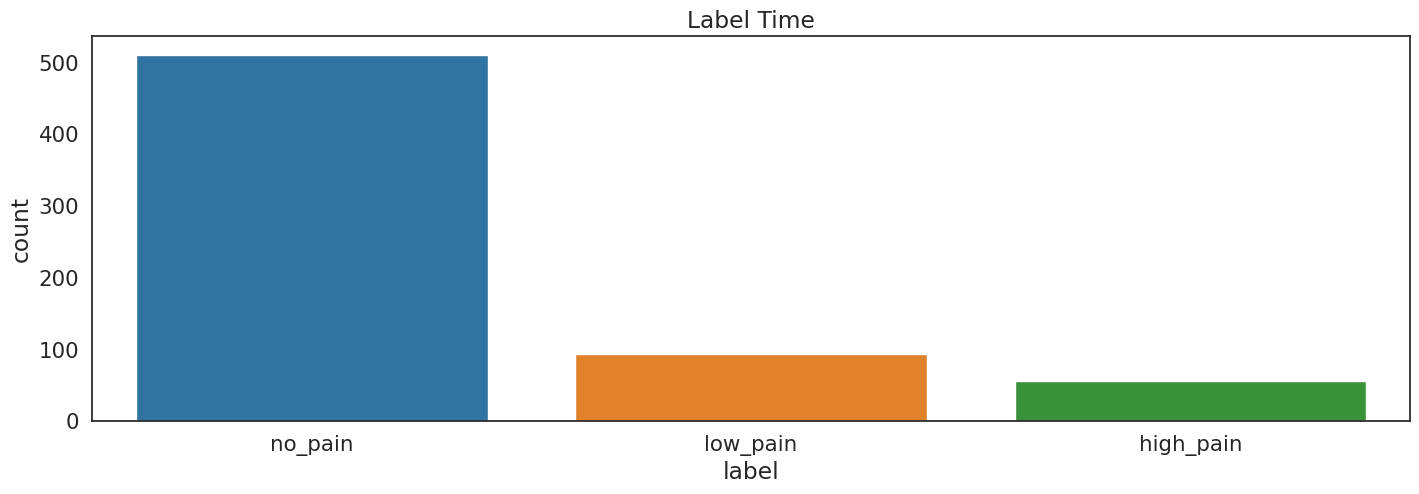

In [46]:

# Visualise the count of time for each label
plt.figure(figsize=(17, 5))
sns.countplot(
    x='label',
    data=df_train_labels,
    order=df_train_labels['label'].value_counts().index,
    palette='tab10'
)

# Set the title of the plot
plt.title('Label Time')

# Display the plot
plt.show()

In [47]:

# count the number of unique pirates
unique_pirates = df_train['sample_index'].unique()
print('number of pirates:',len(unique_pirates))

# verify that each pirate has only one label in the dataset
label_counts = df_train_labels.groupby('sample_index')['label'].nunique()

if (label_counts > 1).any():
    print("\nSome pirates have more than one labels\n")
else:
    print("\nEach pirates has only one label\n")

# now count the time for each pirates, and print if there are of different size
time_for_index = df_train.groupby('sample_index').size()
print(time_for_index)

for i in time_for_index:
  if i != 160:
    print(i, 'not equal')
    break

number of pirates: 661

Each pirates has only one label

sample_index
0      160
1      160
2      160
3      160
4      160
      ... 
656    160
657    160
658    160
659    160
660    160
Length: 661, dtype: int64


## 🔄 **Data Preprocessing**

In [51]:
# Get unique pirate index and shuffle them
unique_pirates = df_train['sample_index'].unique()

random.seed(SEED) # Ensure reproducibility of shuffling
random.shuffle(unique_pirates)
n_total_pirates = len(unique_pirates)

# Define the number of users for validation and test sets
N_TEST_USERS = round(0.2 * n_total_pirates)
N_VAL_USERS = round(0.2 * (n_total_pirates - N_TEST_USERS))

# Calculate the number of users for the training set
n_train_users = len(unique_pirates) - N_VAL_USERS - N_TEST_USERS
print(f'Number of training users: {n_train_users}')
print(f'Number of validation users: {N_VAL_USERS}')
print(f'Number of test users: {N_TEST_USERS}')

# Split the shuffled user IDs into training, validation, and test sets
train_users = unique_pirates[:n_train_users]
val_users = unique_pirates[n_train_users:n_train_users + N_VAL_USERS]
test_users = unique_pirates[n_train_users + N_VAL_USERS:]

# Split the dataset into training, validation, and test sets based on user IDs
dtrain = df_train[df_train['sample_index'].isin(train_users)]
dval = df_train[df_train['sample_index'].isin(val_users)]
dtest = df_train[df_train['sample_index'].isin(test_users)]

dtrain_labels = df_train_labels[df_train_labels['sample_index'].isin(train_users)]
dval_labels = df_train_labels[df_train_labels['sample_index'].isin(val_users)]
dtest_labels = df_train_labels[df_train_labels['sample_index'].isin(test_users)]

# Print the shapes of the training, validation, and test sets
print(f'Training set shape: {dtrain.shape}')
print(f'Validation set shape: {dval.shape}')
print(f'Test set shape: {dtest.shape}')

print(f'\nTraining set shape: {dtrain_labels.shape}')
print(f'Validation set shape: {dval_labels.shape}')
print(f'Test set shape: {dtest_labels.shape}')

Number of training users: 423
Number of validation users: 106
Number of test users: 132
Training set shape: (67680, 37)
Validation set shape: (16960, 37)
Test set shape: (21120, 37)

Training set shape: (423, 2)
Validation set shape: (106, 2)
Test set shape: (132, 2)


In [52]:
# !! I think that we don't need a test set here, we can use the one on kaggle. Just use all the dataset to train and validation

# # Get unique pirate index and shuffle them
# unique_pirates = df_train['sample_index'].unique()

# random.seed(SEED) # Ensure reproducibility of shuffling
# random.shuffle(unique_pirates)
# n_total_pirates = len(unique_pirates)

# # Define the number of users for validation and test sets
# N_VAL_USERS = round(0.2 * n_total_pirates)

# # Calculate the number of users for the training set
# n_train_users = len(unique_pirates) - N_VAL_USERS
# print(f'Number of training users: {n_train_users}')
# print(f'Number of validation users: {N_VAL_USERS}')

# # Split the shuffled user IDs into training and validation sets
# train_users = unique_pirates[:n_train_users]
# val_users = unique_pirates[n_train_users:]

# # Split the dataset into training, validation, and test sets based on user IDs
# dtrain = df_train[df_train['sample_index'].isin(train_users)]
# dval = df_train[df_train['sample_index'].isin(val_users)]

# dtrain_labels = df_train_labels[df_train_labels['sample_index'].isin(train_users)]
# dval_labels = df_train_labels[df_train_labels['sample_index'].isin(val_users)]

# # Print the shapes of the training, validation, and test sets
# print(f'Training set shape: {dtrain.shape}')
# print(f'Validation set shape: {dval.shape}')

# print(f'\nTraining set shape: {dtrain_labels.shape}')
# print(f'Validation set shape: {dval_labels.shape}')

Number of training users: 529
Number of validation users: 132
Training set shape: (84640, 37)
Validation set shape: (21120, 37)

Training set shape: (529, 2)
Validation set shape: (132, 2)


In [54]:
# !!!! now use dtrain,dval,dtest  -> to avoid changing original dataset, this must be better organised in future

# Initialise a dictionary to count occurrences of each label in the training set
training_labels = {
    'no_pain': 0,
    'low_pain': 0,
    'high_pain': 0,
}

# Count occurrences of each activity for unique IDs in the training set
for id in dtrain_labels['sample_index'].unique():
    label = dtrain_labels[dtrain_labels['sample_index'] == id]['label'].values[0]
    training_labels[label] += 1

# Print the distribution of training labels
print('Training labels:', training_labels)

# Count occurrences of each activity for unique IDs in the validation set
val_labels = {
    'no_pain': 0,
    'low_pain': 0,
    'high_pain': 0,
}

# Count occurrences of each activity for unique IDs in the validation set
for id in dval_labels['sample_index'].unique():
    label = dval_labels[dval_labels['sample_index'] == id]['label'].values[0]
    val_labels[label] += 1

# Print the distribution of validation labels
print('Validation labels:', val_labels)


Training labels: {'no_pain': 409, 'low_pain': 75, 'high_pain': 45}
Validation labels: {'no_pain': 102, 'low_pain': 19, 'high_pain': 11}
